# **This notebook was used to test the second API for word segmentation that was used to fine tune the results from the first API (the Microsoft**

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

In [ ]:
!unzip '/content/daniel.zip' -d '/content'

In [ ]:
from PIL import Image
import cv2
import numpy as np
import random


SMALL_HEIGHT = 800

def resize(img, height=SMALL_HEIGHT, allways=False):
    """Resize image to given height."""
    if (img.shape[0] > height or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height=SMALL_HEIGHT):
    """Getting scale ratio."""
    return img.shape[0] / height


def img_extend(img, shape):
    """Extend 2D image (numpy array) in vertical and horizontal direction.
    Shape of result image will match 'shape'
    Args:
        img: image to be extended
        shape: shape (touple) of result image
    Returns:
        Extended image
    """
    x = np.zeros(shape, np.uint8)
    x[:img.shape[0], :img.shape[1]] = img
    return x

def crop_single_word(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,np.ones((1, 1), np.uint8))
    result = _text_detect_word(edge_img)
    return result


def detection2(image, join=False):
    """Detecting the words bounding boxes.
    Return: numpy array of bounding boxes [x, y, x+w, y+h]
    """
    # Preprocess image for word detection
    blurred = cv2.GaussianBlur(image, (5, 5), 18)
    edge_img = _edge_detect(blurred)
    plt.imshow(edge_img, cmap='gray')
    plt.show()

    ret, edge_img = cv2.threshold(edge_img, 50, 255, cv2.THRESH_BINARY)
    plt.imshow(edge_img, cmap='gray')
    plt.show()

    bw_img = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE,np.ones((15, 15), np.uint8))
    plt.imshow(bw_img, cmap='gray')
    plt.show()

    result = _text_detect(edge_img, image, join)
    return result



def sort_words(boxes):
    """Sort boxes - (x, y, x+w, y+h) from left to right, top to bottom."""
    mean_height = sum([y2 - y1 for _, y1, _, y2 in boxes]) / len(boxes)
    
    boxes.view('i8,i8,i8,i8').sort(order=['f1'], axis=0)
    current_line = boxes[0][1]
    lines = []
    tmp_line = []
    for box in boxes:
        if box[1] > current_line + mean_height:
            lines.append(tmp_line)
            tmp_line = [box]
            current_line = box[1]            
            continue
        tmp_line.append(box)
    lines.append(tmp_line)
        
    for line in lines:
        line.sort(key=lambda box: box[0])
        
    return lines


def _edge_detect(im):
    """ 
    Edge detection using sobel operator on each layer individually.
    Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([_sobel_detect(im[:,:, 0]),
                            _sobel_detect(im[:,:, 1]),
                            _sobel_detect(im[:,:, 2])]), axis=0)


def _sobel_detect(channel):
    """Sobel operator."""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def _intersect(a, b, thresh=0):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w + thresh < 0 or h + thresh < 0:
        return False
    return True

def get_primary_contour(cnt_lst):
    area = -1
    primary = []
    for [x, y, w, h] in cnt_lst:
        if w * h > area:
            primary = [x, y, w, h]
            area = w * h
    return primary

def _group_rectangles(rec):
    """
    Uion intersecting rectangles.
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and _intersect(rec[i], rec[j], 10):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1

    return final


def _text_detect(img, image, join=False):
    """Text detection using contours."""
    small = resize(img, 2000)
    H, W = small.shape
    # Finding contours
    kernel = np.ones((5, 30), np.uint16)  ### (5, 100) for line segmention  (5,30) for word segmentation
    #img_dilation = cv2.dilate(small, kernel, iterations=1)
    img_dilation = small

    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        cv2.drawContours(img_dilation, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = img_dilation[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text
        #if (r > 0.1) and h < H/5 and w < W/2 and h/w < 3:
        if (r > 0.1
            and 1600 > w > 10
            and 1600 > h > 10
            and h/w < 3
            and w/h < 10
            and (60 // h) * w < 1000):
            boxes += [[x, y, w, h]]
            
        index = hierarchy[0][index][0]
    if join:
        boxes = _group_rectangles(boxes)

    # remove contours that are too small
    mean_area = np.mean([w*h for [x,y,w,h] in boxes])
    boxes = [rect for rect in boxes if rect[2] * rect[3] > mean_area/15]

    # image for drawing bounding boxes
    small = cv2.cvtColor(small, cv2.COLOR_GRAY2RGB)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(small, (x, y),(x+w,y+h), (0, 255, 0), 2)
        bounding_boxes = np.vstack((bounding_boxes,
                                    np.array([x, y, x+w, y+h])))
    plt.imshow(small)
    plt.show()
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    return boxes[1:]  

def _text_detect_word(img):
    """Text detection using contours."""
    small = img
    H, W = small.shape
    # Finding contours
    kernel = np.ones((5, 100), np.uint16)  ### (5, 100) for line segmention  (5,30) for word segmentation
    img_dilation = cv2.dilate(small, kernel, iterations=1)
    img_dilation = small

    cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    index = 0    
    boxes = []
    # Go through all contours in top level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])  
        boxes += [[x, y, w, h]] 
        index = hierarchy[0][index][0]

    boxes = _group_rectangles(boxes)
    # image for drawing bounding boxes
    small = cv2.cvtColor(small, cv2.COLOR_GRAY2RGB)
    bounding_boxes = np.array([0,0,0,0])
    boxes = get_primary_contour(boxes)
    (x, y, w, h) = boxes
    cv2.rectangle(small, (x, y),(x+w,y+h), (0, 255, 0), 2)
    bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x+w, y+h])))
    plt.imshow(small)
    plt.show()
    return boxes

def crop_document(document_img):
    #crop = detection1(document_img)
    boxes = detection2(document_img)
    lines = sort_words(boxes)
    imgs = []
    bboxes = []
    spaces = []
    new_lines = []
    for j in range(len(lines)):
        line = lines[j]
        size = len(line)
        for i in range(size):
            x1, y1, x2, y2 = line[i]
            imgs.append(document_img[y1:y2, x1:x2])
            bboxes.append((x1, y1, x2, y2))
            space = 0
            if i < size - 1:
                a1, b1, a2, b2 = line[i+1]
                space = a1 - x2
            spaces.append(space)
        if j < len(lines) - 1:
          new_line = lines[j+1][0][1] - lines[j][0][1]  # diff heights between lines
        else:
          new_line = np.mean(new_lines)
        new_lines.append(new_line)
    
    return imgs, bboxes, spaces, new_lines


def fix_brightness(img):
    high = 140
    h, w = img.shape
    new = img.copy()
    for i in range(h):
        for j in range(w):
            current = new[i][j]
            if current > high:
                new[i][j] = 255
    return new
    
class Word:
    def __init__(self, img, label=None, pos_w=0, pos_h=0, space=None):
        self.img = img
        self.label = label
        self.h, self.w = img.shape[0:2]
        self.top_left_w = pos_w
        self.top_left_h = pos_h
        if space is None:
            space_range = (8, 35)
            self.space = random.randint(*space_range)
        else:
            self.space = space

    def print(self):
        print((self.label, self.top_left_h, self.top_left_w, self.space), end=' ')

    def set_space(self, space):
        self.space = space

class Document:
    def __init__(self):
        self.document_img = self.create_new_document()
        self.words = []  # array of class: Word

    def __init__(self, h, w, new_lines=[]):
            self.document_img = self.create_new_document(h, w)
            self.words = []  # array of class: Word
            self.new_lines = new_lines

    def print(self):
      arr = []
      for word in self.words:
          arr.append((word.label, word.top_left_h, word.top_left_w, word.space))
      print(arr)
    
    def get_new_line(self):
        if len(self.new_lines) > 0:
            newl= self.new_lines.pop(0)
        else:
            newl = np.mean([word.h for word in self.words])
        return int(newl)

    def set_space(self, word : Word):
        if word.space == 0 or word.space is None:
            new_space = np.mean([word.space for word in self.words])
            word.space = int(new_space)

    def set_space_manually(self, word : Word, space):
        word.set_space(space)
        self.repaint()

    def set_new_lines(self, height):
        self.new_lines = [height for x in range(20)]
        self.repaint()

    def create_new_document(self, h=5*64, w=500):
        self.document_width = w
        self.margin = self.document_width // 20
        self.document_height = h
        shape = (self.document_height, self.document_width)
        document_img = 255 * np.ones(shape, dtype=np.uint8)
        return document_img

    def clear_document_img(self):
        self.document_img = 255 * np.ones(self.document_img.shape, dtype=np.uint8)

    def append_word(self, word : Word):
        self.set_space(word)
        self.words.append(word)
        self.repaint()

    # public method to be called to from outside
    def add_word(self, word : Word, index):
        if index < len(self.words):
            self.words.insert(index, word)
        else:
            self.append_word(word)
        self.repaint()
    
    # public method to be called to from outside
    def delete_word(self, index):
        print('delete at', index)
        if index < len(self.words) and index >=0:
            self.words.pop(index)
        else:
            self.words.pop()
        self.repaint()

    # public method to be called to from outside
    def copy_word_from_existing_document(self, word : Word):
        self.set_space(word)
        self.words.append(word)
        self.paint_word(word)
    
    def repaint(self):
        self.clear_document_img()
        start_h = self.margin
        start_w = self.margin
        
        for word in self.words:
            if start_w + word.w > self.document_width - self.margin:
                    start_w = self.margin;
                    start_h += self.get_new_line()
            word.top_left_h = start_h
            word.top_left_w = start_w
            self.paint_word(word)
            start_w += (word.w + word.space)


    def plot_doc(self):
        plt.imshow(self.document_img, cmap='gray')
        plt.show()

    def paint_word(self, word: Word):
        try:
          self.document_img[word.top_left_h : word.top_left_h + word.h, word.top_left_w : word.top_left_w + word.w] = word.img
        except Exception as e:
          word.print()
          print('Paint word failed!', e)


def copy_existing_document(src_img, imgs, bboxes, spaces_list, new_lines):
    size = len(imgs)
    gray = len(src_img.shape) == 2
    if gray:
        h, w = src_img.shape
    else:
        h, w, c = src_img.shape

    doc = Document(h, w, new_lines)
    for i in range(size):
        current_space = spaces_list[i] if i < len(spaces_list) else None
        current_word = Word(imgs[i] if gray else cv2.cvtColor(imgs[i], cv2.COLOR_RGB2GRAY), pos_h=bboxes[i][1], pos_w=bboxes[i][0], space=current_space)
        doc.copy_word_from_existing_document(current_word)
        if i == 5:
            a = current_word
        if i == 3:
            b = current_word

    plt.imshow(doc.document_img, cmap='gray')
    plt.show()        
   
    return doc
     

def init_existing_document(document_img=None):
    if document_img is not None:
        imgs, bboxes, spaces, new_lines = crop_document(document_img)
        doc = copy_existing_document(document_img, imgs, bboxes, spaces, new_lines)
        #doc.set_new_lines(150)
    else:
        doc = Document(1000, 1500)
    doc.document_img = fix_brightness(doc.document_img)
    plt.imshow(doc.document_img, cmap='gray')
    plt.show()



In [ ]:
original = cv2.imread("/content/hand2.jpg")
plt.imshow(original, cmap='gray')
plt.show()
document_img = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
init_existing_document(document_img)

In [ ]:
original = cv2.imread("/content/hand.jpeg")
plt.imshow(original, cmap='gray')
plt.show()
document_img = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
init_existing_document(document_img)

In [ ]:
original = cv2.imread("/content/test.jpg")
plt.imshow(original, cmap='gray')
plt.show()
document_img = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
init_existing_document(document_img)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

# **Testing crop single word**

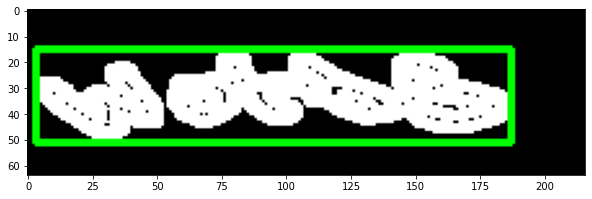

[3, 15, 184, 36]


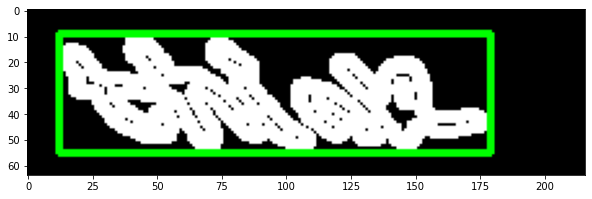

[12, 9, 167, 46]


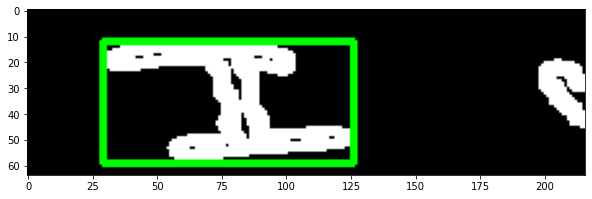

[29, 12, 97, 47]


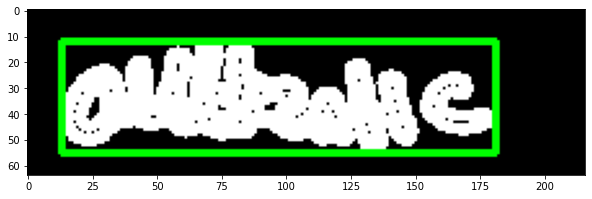

[13, 12, 168, 43]


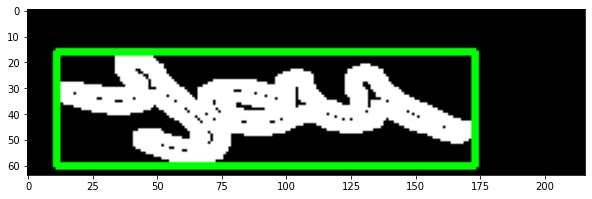

[11, 16, 162, 44]


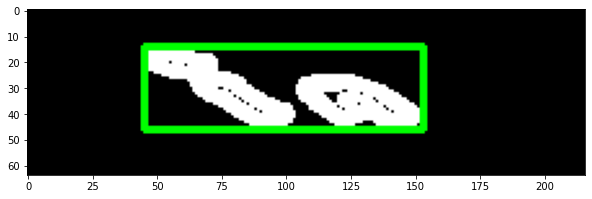

[45, 14, 108, 32]


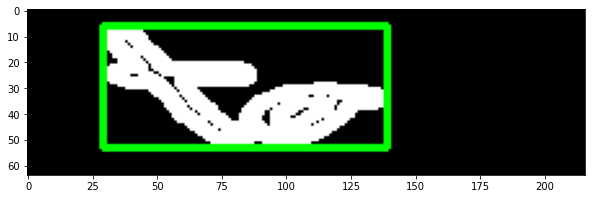

[29, 6, 110, 47]


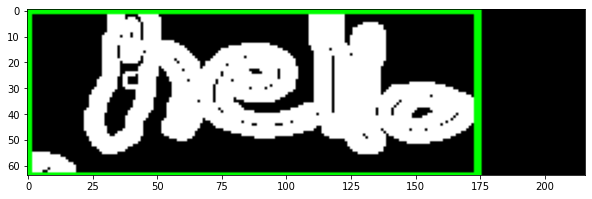

[0, 0, 174, 64]


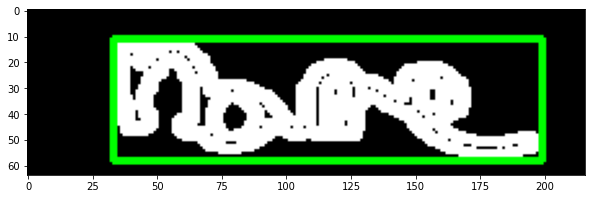

[33, 11, 166, 47]


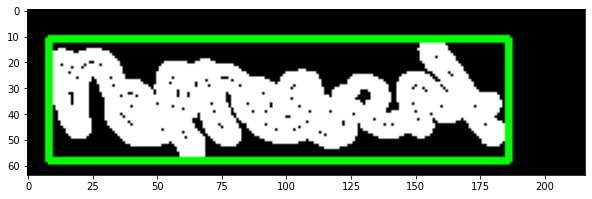

[8, 11, 178, 47]


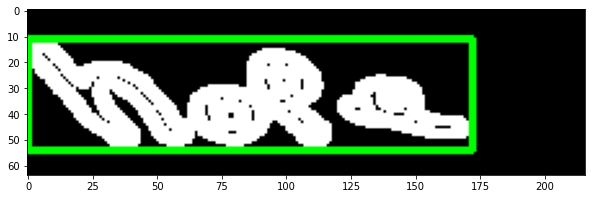

[0, 11, 172, 43]


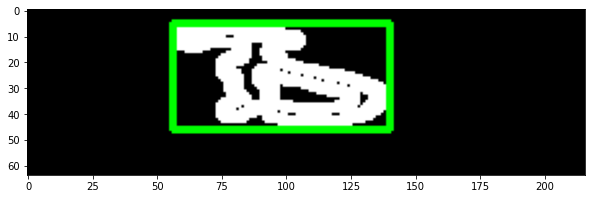

[56, 5, 84, 41]


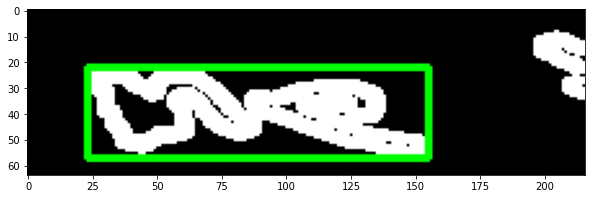

[23, 22, 132, 35]


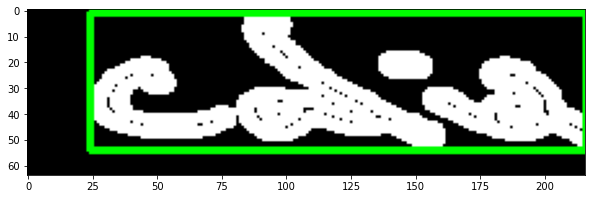

[24, 1, 192, 53]


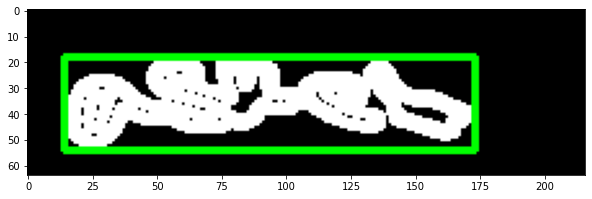

[14, 18, 159, 36]


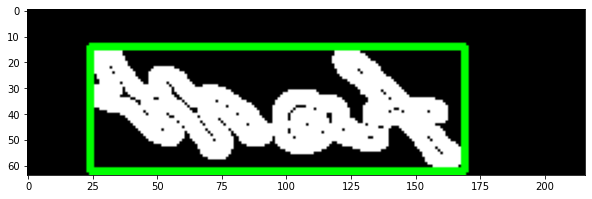

[24, 14, 145, 48]


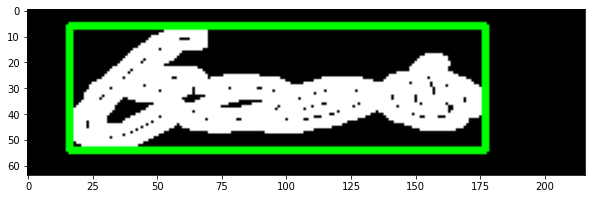

[16, 6, 161, 48]


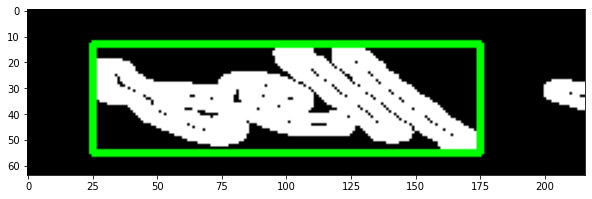

[25, 13, 150, 42]


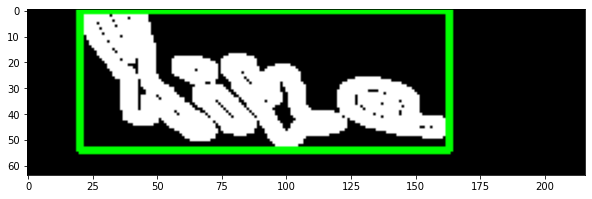

[20, 0, 143, 54]


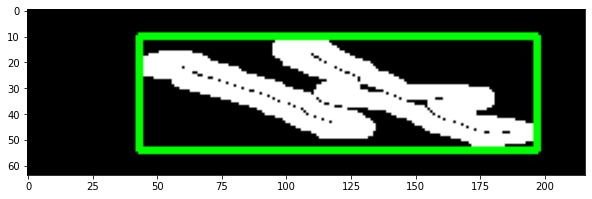

[43, 10, 154, 44]


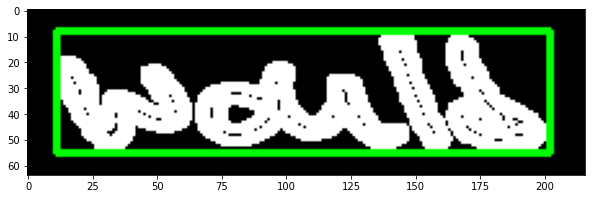

[11, 8, 191, 47]


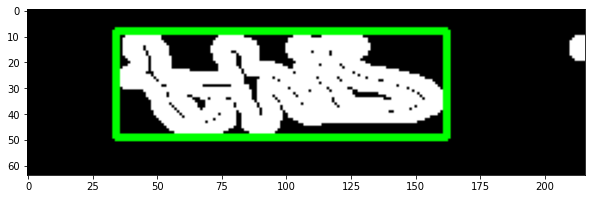

[34, 8, 128, 41]


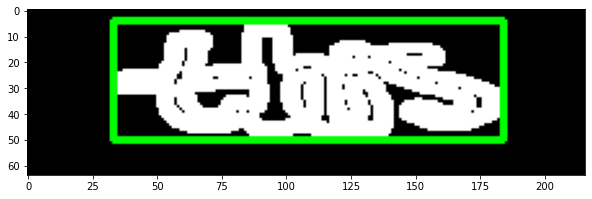

[33, 4, 151, 46]


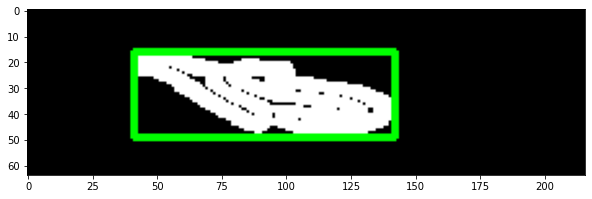

[41, 16, 101, 33]


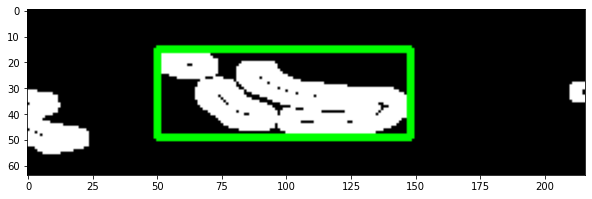

[50, 15, 98, 34]


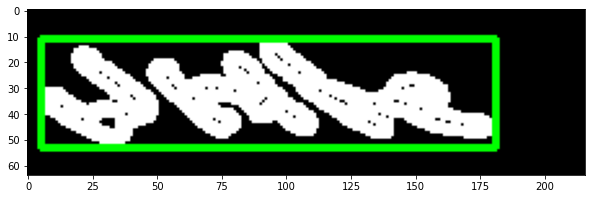

[5, 11, 176, 42]


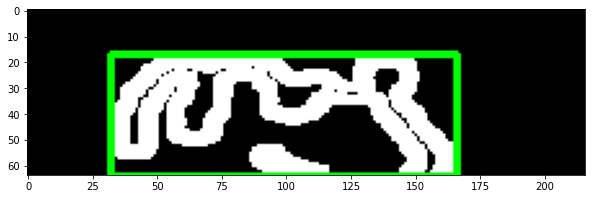

[32, 17, 134, 47]


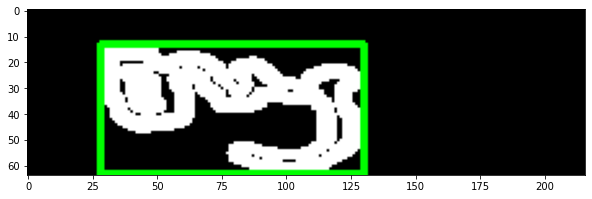

[28, 13, 102, 50]


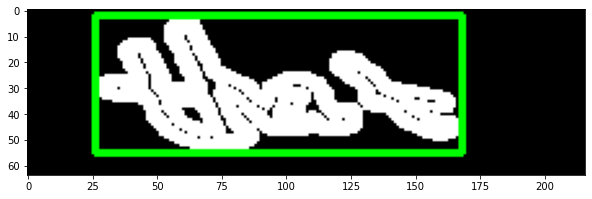

[26, 2, 142, 53]


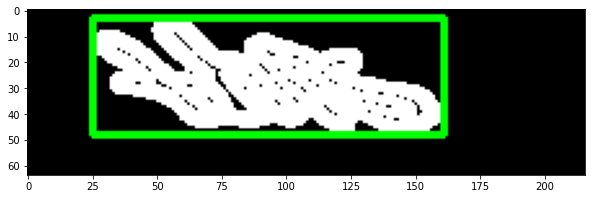

[25, 3, 136, 45]


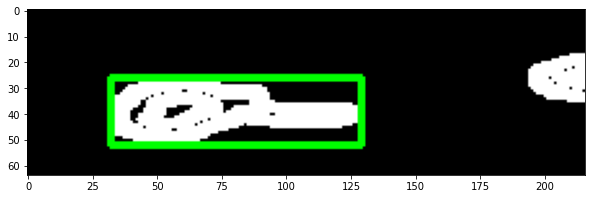

[32, 26, 97, 26]


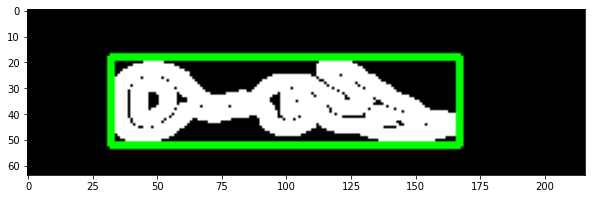

[32, 18, 135, 34]


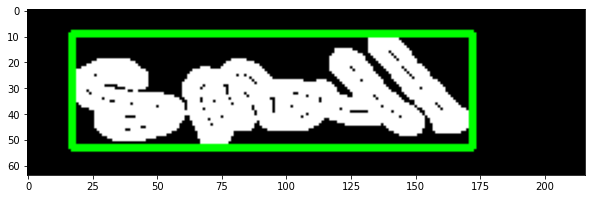

[17, 9, 155, 44]


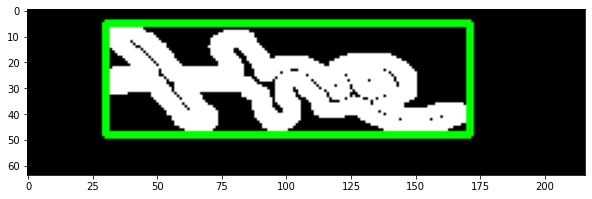

[30, 5, 141, 43]


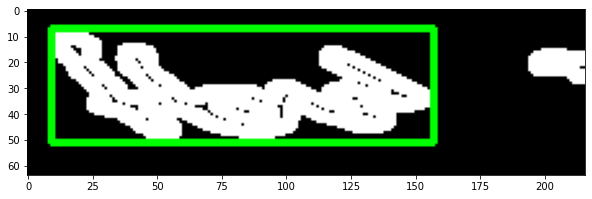

[9, 7, 148, 44]


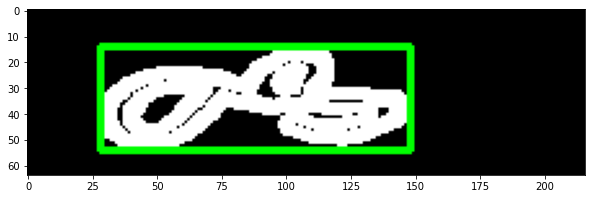

[28, 14, 120, 40]


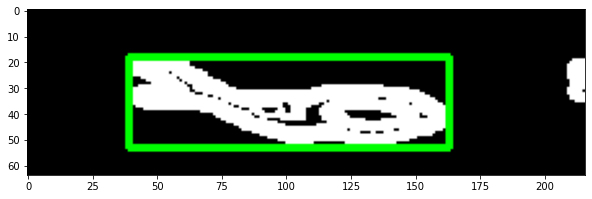

[39, 18, 124, 35]


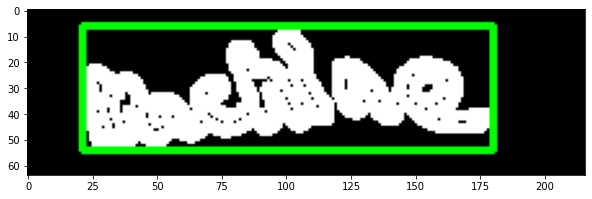

[21, 6, 159, 48]


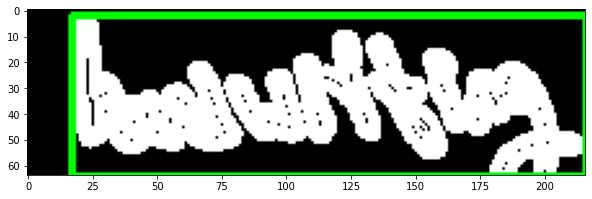

[17, 2, 199, 62]


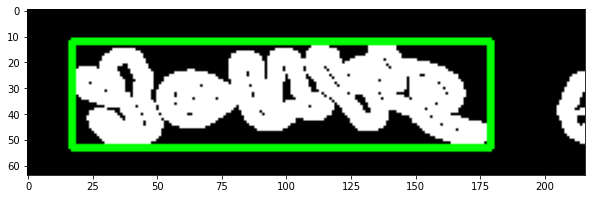

[17, 12, 162, 41]


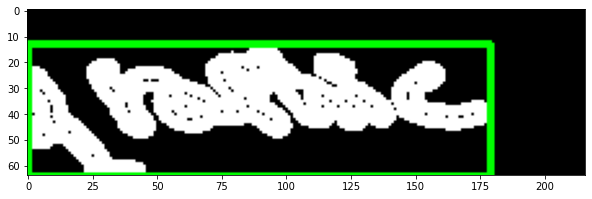

[0, 13, 179, 51]


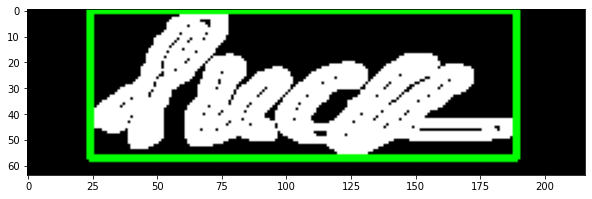

[24, 0, 165, 57]


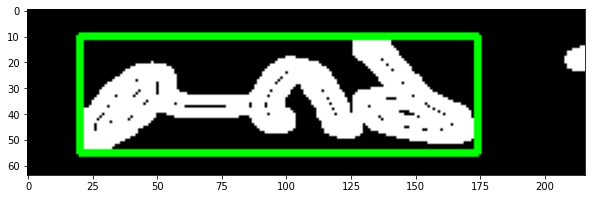

[20, 10, 154, 45]


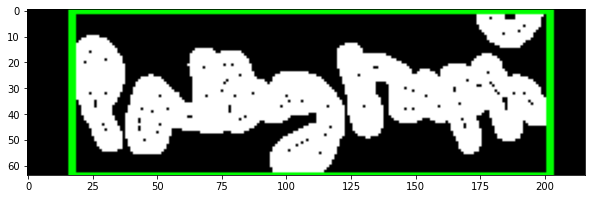

[17, 0, 185, 64]


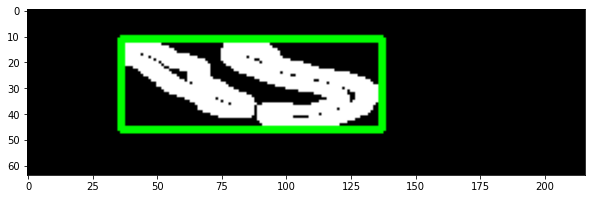

[36, 11, 101, 35]


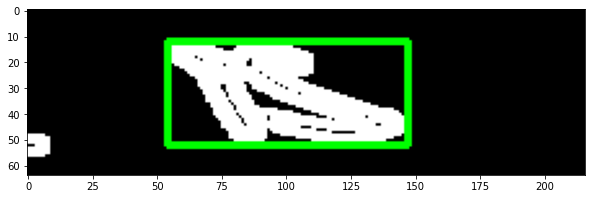

[54, 12, 93, 40]


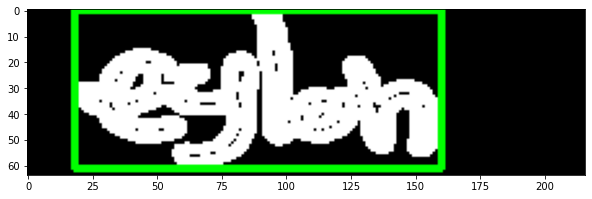

[18, 0, 142, 61]


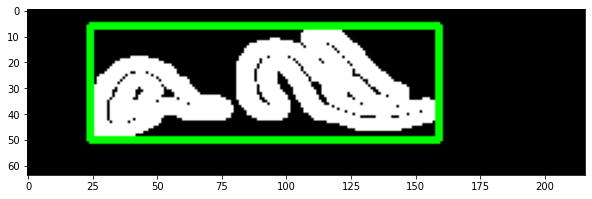

[24, 6, 135, 44]


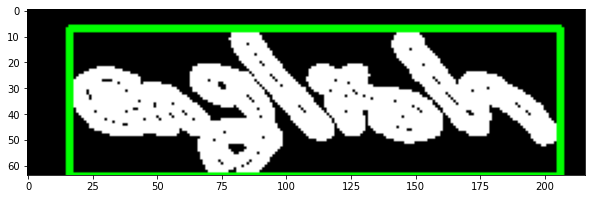

[16, 7, 190, 57]


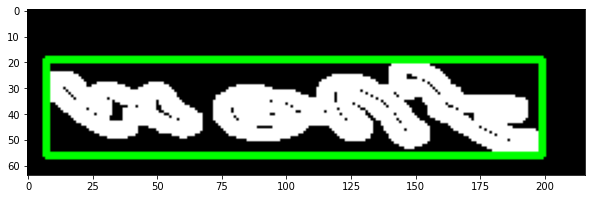

[7, 19, 192, 37]


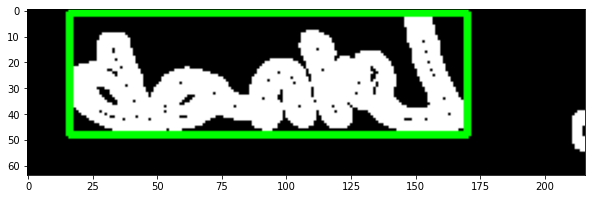

[16, 1, 154, 47]


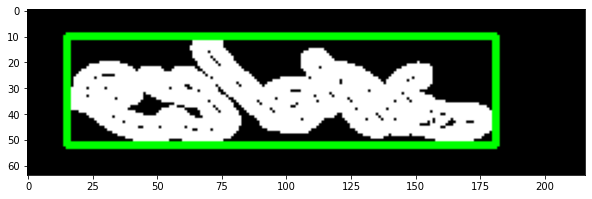

[15, 10, 166, 42]


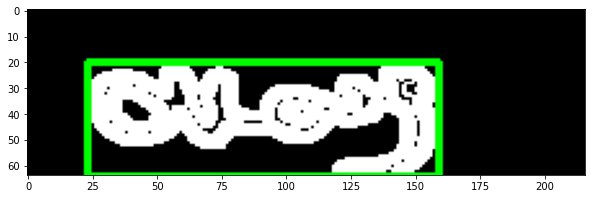

[23, 20, 136, 44]


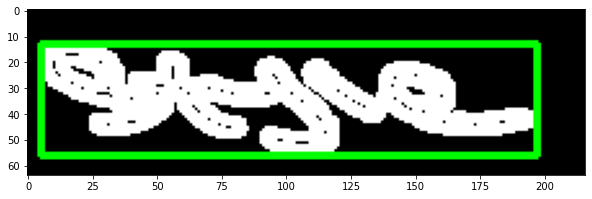

[5, 13, 192, 43]


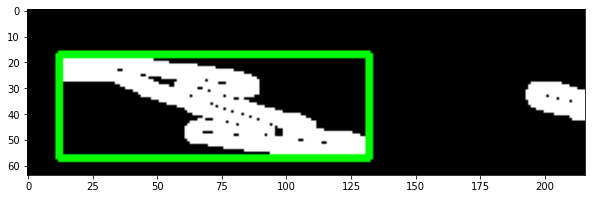

[12, 17, 120, 40]


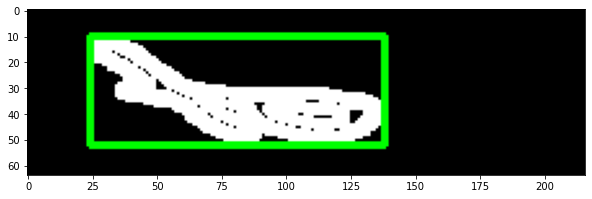

[24, 10, 114, 42]


In [ ]:
from glob import glob
lst = glob('/content/daniel/*')
for path in lst:
    pic = cv2.imread(path)
    bboxes = crop_single_word(pic)
    print(bboxes)